# Tutorial: Estimating Genome Size

Flow cytometry is regularly used to estimate genome size relative to a standard, often in plants. Nuclei are isolated from a plant of unknown genome size and from a plant of known genome size; the samples are mixed, stained with a fluorescent DNA-binding dye such as DAPI, and run on a flow cytometer. The relative fluorescences can be used to estimate the size of the unknown genome relative to the known one.

This tutorial demonstrates one possible approach. We use data from **Kúr et al. Cryptic invasion suggested by a cytogeographic analysis of the halophytic Puccinellia distans complex (Poaceae) in Central Europe. Frontiers in Plant Science 14, 2023** [DOI: 10.3389/fpls.2023.1249292](https://doi.org/10.3389/fpls.2023.1249292). No pre-processing was done – these are the raw files downloaded from the publication’s dataset on Zenodo. I did remove one file whose data looked pretty wonky – the investigators do the same with several of their samples.

If you’d like to follow along, you can do so by downloading one of the **cytoflow-#####-examples-basic.zip** files from the Cytoflow releases page on GitHub. These data are in the **data/genome_size** subfolder.

## Set up Cytoflow and import the data

In [1]:
import cytoflow as flow

# if your figures are too big or too small, you can scale them by changing matplotlib's DPI
import matplotlib
# matplotlib.rc('figure', dpi = 160)

Because we don't have any metadata besides the filename, use that as the metadata.

In [2]:
# Use glob to get the files and parse the conditions back out.

import glob, re
tubes = []

for f in glob.glob("data/genome_size/*.fcs"):
    r = re.search("data/genome_size/(.*?)\\.fcs", f)
    sample = r.group(1)
    
    tube = flow.Tube(file = f, conditions = {"Sample" : sample})
    tubes.append(tube)
    
ex = flow.ImportOp(tubes = tubes,
                   conditions = {"Sample" : "category"},
                   ignore_v = ["SSC", "FL1"]).apply()

/home/brian/src/cytoflow/fcsparser/fcsparser/api.py:300: UserWarning: There appears to be some information in the ANALYSIS segment of file data/genome_size/PU88@5+B200.fcs. However, it might not be read correctly.
/home/brian/src/cytoflow/fcsparser/fcsparser/api.py:501: UserWarning: The default channel names (defined by the $PnS parameter in the FCS file) were not unique. To avoid problems in downstream analysis, the channel names have been switched to the alternate channel names defined in the FCS file. To avoid seeing this warning message, explicitly instruct the FCS parser to use the alternate channel names by specifying the channel_naming parameter.
/home/brian/src/cytoflow/fcsparser/fcsparser/api.py:300: UserWarning: There appears to be some information in the ANALYSIS segment of file data/genome_size/PU87@11+B200.fcs. However, it might not be read correctly.
/home/brian/src/cytoflow/fcsparser/fcsparser/api.py:501: UserWarning: The default channel names (defined by the $PnS parame

Usually, `Cytoflow` imposes a constraint that a channel’s voltages are the same for each FCS file it imports. With care, this can allow you to compare quantitative measurements across FCS files. However, occasionally you need to relax this constraint, and this is one of those times – a few of these FCS files have slightly different voltages. However, because the standard is spiked into each sample, we can safely proceed. So, we set `ignore_v` to a list of channels where we would like to ignore the voltage.

And what about all those warnings? Occasionally an instrument manufacturer’s software saves files a little strangely. Cytoflow knows about a lot of these issues and fixes them for you, but it will also warn you that the data it is analyzing is not exactly the data in the FCS files.

## Take a look at the data

It’s always good to start with some basic data exploration.

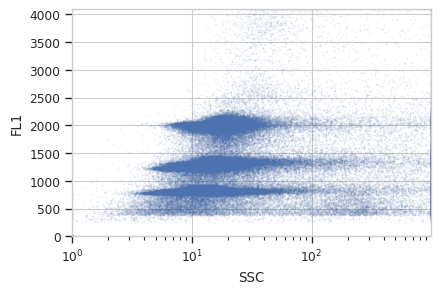

In [3]:
flow.ScatterplotView(xchannel = "SSC",
                     xscale = "log",
                     ychannel = "FL1",
                     yscale = "linear").plot(ex, s = 0.2, alpha = 0.1)

Here, there are only two channels saved (in addition to Time), so have a look at the scatter plot. Notice that there are three major clusters – the lower FL1 cluster is our internal standard, and the higher two clusters are the nulcei we’re trying to estimate. There’s also quite a bit of noise, which might make that estimation inaccurate – we’ll think about that in a minute.

(Remember, unless you facet or subset your plot – which we’re not doing here – you’re looking at the whole data set, all of the tubes together on one plot.)

## Gate out high-SSC events

There are a bunch of events piled up at the top of the SSC channel, and those will interfere with subsequent analysis. Let's get rid of them with a `Threshold Gate`.

In [4]:
ex_gated = flow.ThresholdOp(name = "Huge_SSC",
                            channel = "SSC",
                            threshold = 500).apply(ex)

## Find the peaks with a density gate

Let’s assume, for the moment, that we don’t want to draw 40 different gates to find the two peaks in each of our 20 samples. What to do? `Cytoflow` includes several automated clustering algorithms, and the one that works best in this situation is a `Density Gate`. The user selects how much of the data they would like to retain, and this gate selects that proportion of events in the highest-density regions of a 2D plot. Most important for our use, *we don’t have to use the same gate for the entire data set.* Like most data-driven operations, the `Density Gate` lets you group the data by some condition or piece of metadata before estimating the operation’s parameters. In this case, we’ll compute a different gate for each tube.

After exploring several different parameters, let's keep 45% of the data. We'll gate on the `SSC` and `FL1` channels, same as the scatterplot. Change `xscale` from `log` to `logicle`, though. To make a different gate for each tube, set `by` to `["Sample"]`. And make sure we set `subset` to `Huge_SSC == False` to ignore the events with huge SSCs.

In [5]:
density_gate = flow.DensityGateOp(name = "Density",
                                  xchannel = "SSC",
                                  xscale = "logicle",
                                  ychannel = "FL1",
                                  yscale = "linear",
                                  keep = 0.45,
                                  by = ["Sample"])
density_gate.estimate(ex_gated, subset = "Huge_SSC == False")

/home/brian/src/cytoflow/cytoflow/utility/logicle_scale.py:320: CytoflowWarning: Channel SSC doesn't have any negative data. Try a log transform instead.


Now, iterate over all of the plots and make sure that we got a gate that looks reasonable for each sample.

/home/brian/.local/lib/anaconda/envs/cf_dev/lib/python3.12/site-packages/seaborn/axisgrid.py:453: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


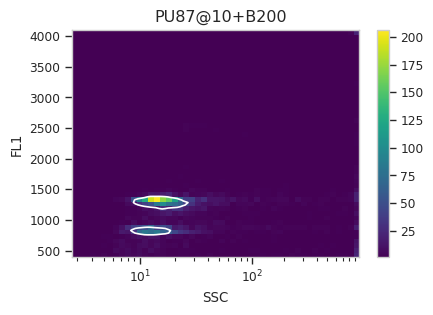

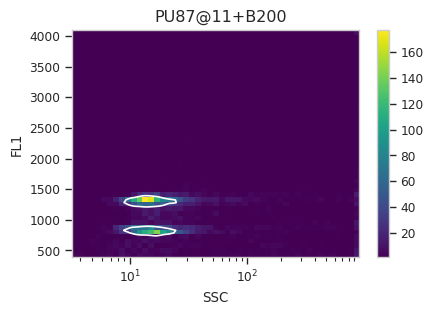

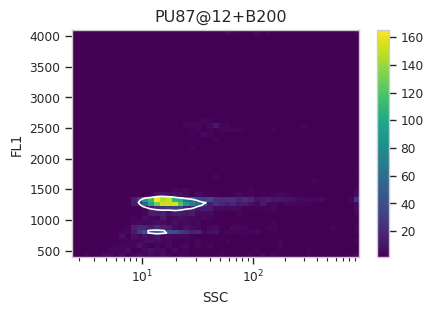

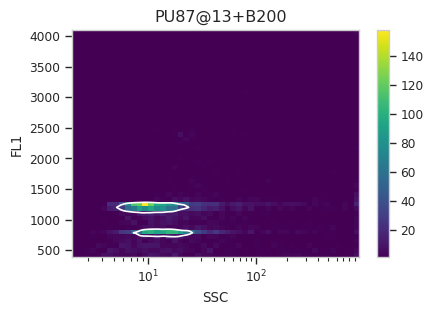

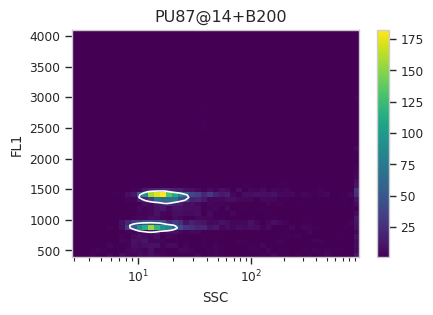

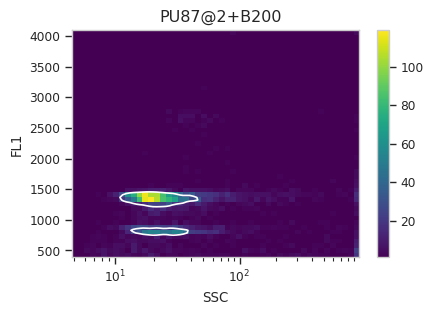

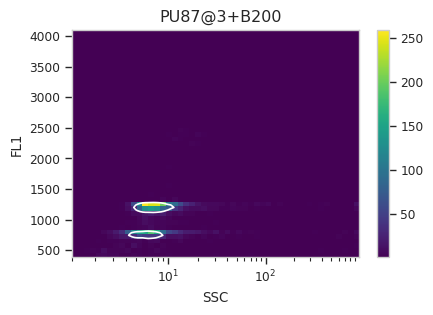

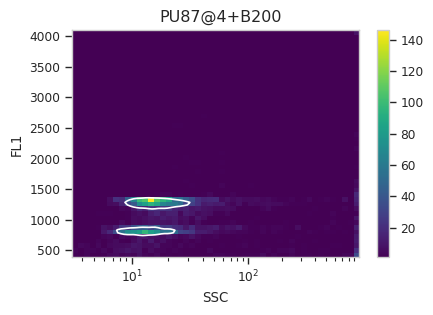

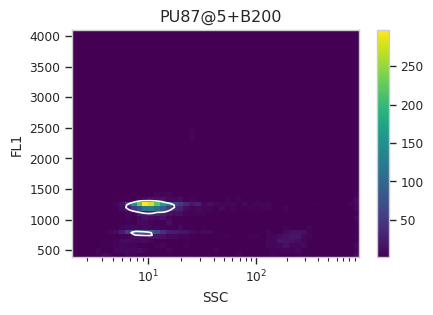

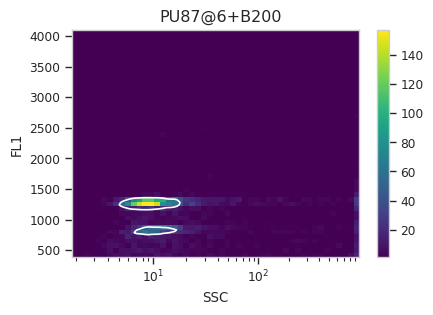

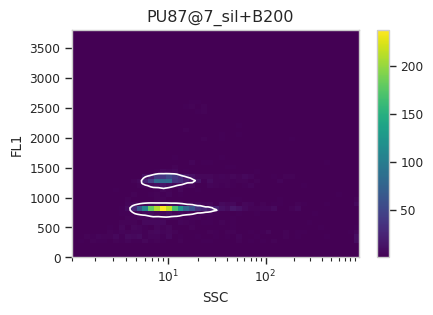

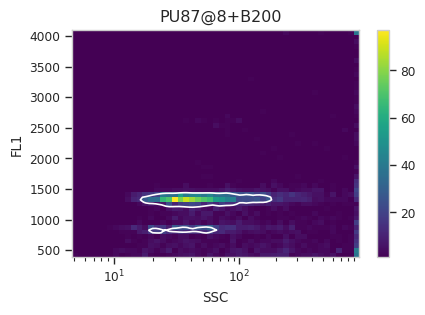

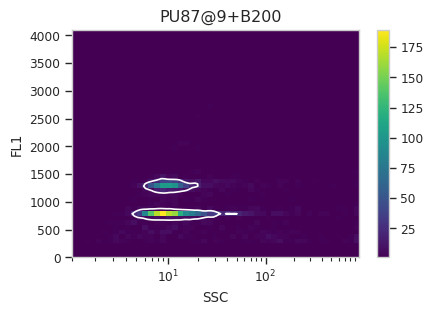

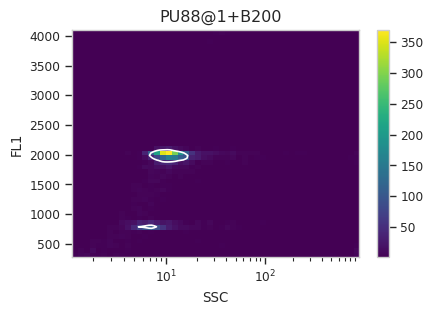

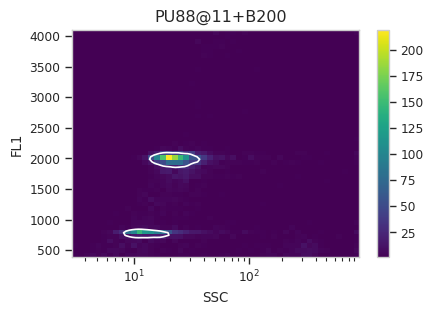

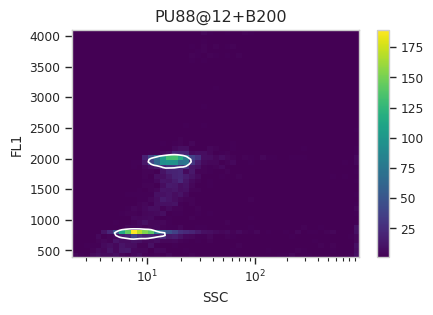

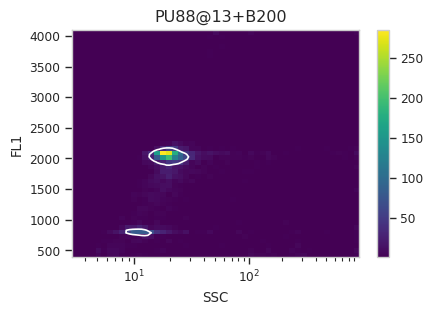

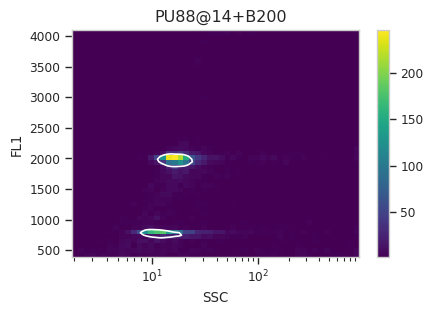

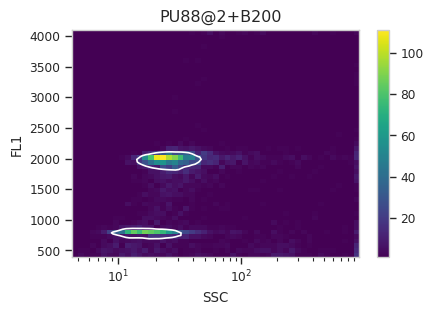

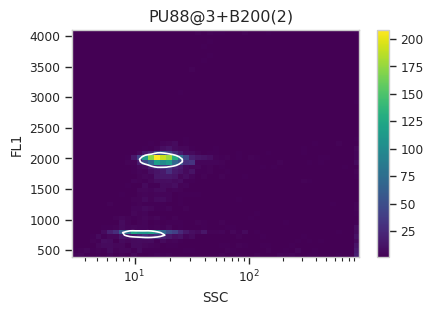

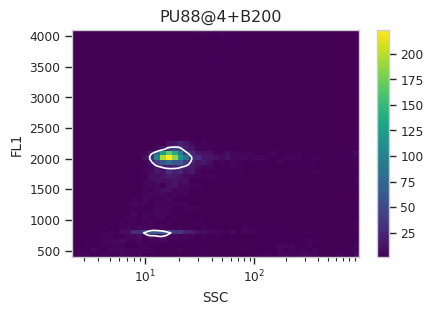

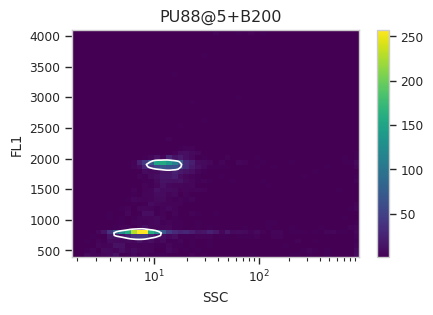

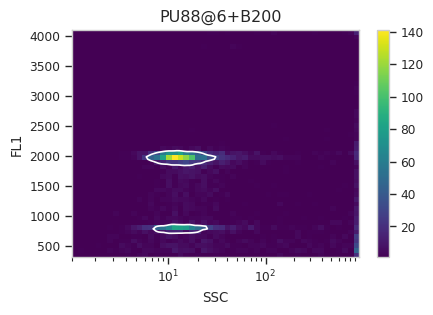

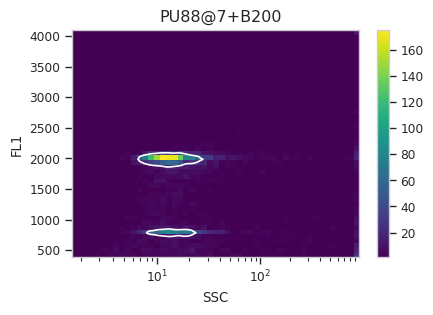

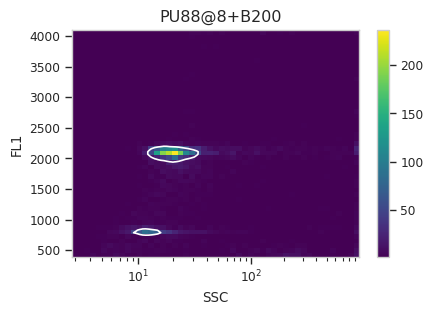

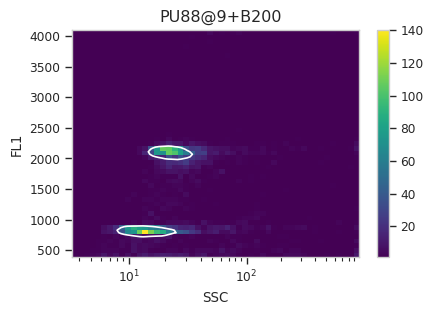

In [6]:
for plot_name in density_gate.default_view().enum_plots(ex_gated):
    density_gate.default_view().plot(ex_gated, plot_name = plot_name, title = plot_name)

Looks good! And why change the X scale? This was an issue I caught as I scrolled through the gates – there was a gate with strange behavior with events with very small `SSC`s. I could have gated them out, I suppose, or I could change the scale – `logicle` behaves much better around 0 than `log` does.

Let's apply the gate and move on.

In [7]:
ex_density = density_gate.apply(ex_gated)

/home/brian/src/cytoflow/cytoflow/utility/logicle_scale.py:320: CytoflowWarning: Channel SSC doesn't have any negative data. Try a log transform instead.


## Separate the control and sample peak

We’ve found the peaks, but if we want to summarize the different peaks’ means separately, we need to separate them. Let’s do so with another `Threshold` gate – this one I’ll name `Unknown`, to distinguish the spike-in sample (`Unknown == False`) from the events we want to measure (`Unknown == True`).

Note that in the view, I’ve shown only the subset for which `Density == True` – this hides all the events that weren’t in the peaks and cleans up the plot substantially.

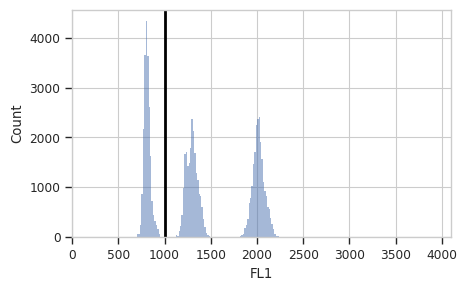

In [8]:
threshold_op = flow.ThresholdOp(name = "Unknown",
                                channel = "FL1",
                                threshold = 1000)
threshold_op.default_view(subset = "Density == True").plot(ex_density)

In [9]:
ex_threshold = threshold_op.apply(ex_density)

## Compute the peaks' means

We're almost done. Recall that in `Cytoflow`, if we want to summarize some flow data, we do so by creating a *statistic*. So let's create one using the `ChannelStatisticOp` operation. We'll get each distinct subset of `Sample` and `Standard`, then apply `np.mean` and save in a statistic named `Mean`.

In [10]:
import numpy as np
ex_mean = flow.ChannelStatisticOp(name = "Mean",
                                  channel = "FL1",
                                  function = np.mean,
                                  by = ["Sample", "Unknown"],
                                  subset = "Density == True").apply(ex_threshold)
ex_mean.statistics['Mean']

FL1
Sample          Unknown             
PU87@10+B200    False     837.876204
                True     1308.596886
PU87@11+B200    False     837.271686
                True     1320.092908
PU87@12+B200    False     825.947059
                True     1293.881644
PU87@13+B200    False     804.640094
                True     1220.929577
PU87@14+B200    False     900.000967
                True     1393.757658
PU87@2+B200     False     828.260794
                True     1364.768903
PU87@3+B200     False     775.346457
                True     1224.151099
PU87@4+B200     False     830.764826
                True     1293.239563
PU87@5+B200     False     793.494881
                True     1231.083259
PU87@6+B200     False     839.064236
                True     1282.589608
PU87@7_sil+B200 False     821.028060
                True     1303.553441
PU87@8+B200     False     847.688811
                True     1350.027876
PU87@9+B200     False     797.452258
                True     1309.014458
PU88@1+B200     False     811.518106
                True     2005.262701
PU88@11+B200    False     791.330855
                True     2003.251294
PU88@12+B200    False     788.473770
                True     1977.615936
PU88@13+B200    False     816.856079
                True     2058.079467
PU88@14+B200    False     790.418095
                True     1996.551899
PU88@2+B200     False     797.595672
                True     1992.682345
PU88@3+B200(2)  False     784.629487
                True     1993.387588
PU88@4+B200     False     800.509960
                True     2032.551757
PU88@5+B200     False     786.311507
                True     1916.499501
PU88@6+B200     False     808.929134
                True     1989.944548
PU88@7+B200     False     809.851351
                True     2006.164361
PU88@8+B200     False     816.540984
                True     2099.449713
PU88@9+B200     False     832.135174
                True     2119.060337

Remember, a statistic is just a `pandas.DataFrame` with a hierarchical index. So, if we want a table with a row for each sample and the `Unknown == True` and `Unknown == False` values in separate columns, we can reshape the data using `pandas.DataFrame.unstack`, like so:

In [11]:
ex_mean.statistics['Mean'].unstack(level = "Unknown")

FL1             
Unknown               False        True 
Sample                                  
PU87@10+B200     837.876204  1308.596886
PU87@11+B200     837.271686  1320.092908
PU87@12+B200     825.947059  1293.881644
PU87@13+B200     804.640094  1220.929577
PU87@14+B200     900.000967  1393.757658
PU87@2+B200      828.260794  1364.768903
PU87@3+B200      775.346457  1224.151099
PU87@4+B200      830.764826  1293.239563
PU87@5+B200      793.494881  1231.083259
PU87@6+B200      839.064236  1282.589608
PU87@7_sil+B200  821.028060  1303.553441
PU87@8+B200      847.688811  1350.027876
PU87@9+B200      797.452258  1309.014458
PU88@1+B200      811.518106  2005.262701
PU88@11+B200     791.330855  2003.251294
PU88@12+B200     788.473770  1977.615936
PU88@13+B200     816.856079  2058.079467
PU88@14+B200     790.418095  1996.551899
PU88@2+B200      797.595672  1992.682345
PU88@3+B200(2)   784.629487  1993.387588
PU88@4+B200      800.509960  2032.551757
PU88@5+B200      786.311507  1916.499501
PU88@6+B200      808.929134  1989.944548
PU88@7+B200      809.851351  2006.164361
PU88@8+B200      816.540984  2099.449713
PU88@9+B200      832.135174  2119.060337

Getting the ratio between the two and converting to a pg/genome estimate is left as an exercise for the reader!